In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import pickle

import warnings

warnings.filterwarnings('ignore')

### Load data from txt files

In [2]:
time_feature = pd.read_csv('data/time_feature.txt', sep=';')
road_feature = pd.read_csv('data/road_feature.txt', sep=';')

In [3]:
time_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19395095 entries, 0 to 19395094
Data columns (total 5 columns):
 #   Column                Dtype  
---  ------                -----  
 0   linkID                float64
 1   start_time            object 
 2   travel_time           float64
 3   combined_hour_day     object 
 4   avg_travel_time_hour  float64
dtypes: float64(3), object(2)
memory usage: 739.9+ MB


In [4]:
road_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   linkID                  132 non-null    uint64 
 1   travel_time_avg         132 non-null    float64
 2   length                  132 non-null    int64  
 3   width                   132 non-null    int64  
 4   area                    132 non-null    int64  
 5   in_link_count           132 non-null    int64  
 6   out_link_count          132 non-null    int64  
 7   link_count_combination  132 non-null    object 
dtypes: float64(1), int64(5), object(1), uint64(1)
memory usage: 8.4+ KB


# Experiment

In [5]:
def encode_data(data, col_name):
    # 将combined_hour_day编码为数值
    label_encoder = LabelEncoder()
    encode_name = col_name+'_encode'
    data[encode_name] = label_encoder.fit_transform(data[col_name])
    return data

In [6]:
time_data = encode_data(time_feature, 'combined_hour_day')
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19395095 entries, 0 to 19395094
Data columns (total 6 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   linkID                    float64
 1   start_time                object 
 2   travel_time               float64
 3   combined_hour_day         object 
 4   avg_travel_time_hour      float64
 5   combined_hour_day_encode  int32  
dtypes: float64(3), int32(1), object(2)
memory usage: 813.9+ MB


In [7]:
road_data = encode_data(road_feature, 'link_count_combination')
road_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   linkID                         132 non-null    uint64 
 1   travel_time_avg                132 non-null    float64
 2   length                         132 non-null    int64  
 3   width                          132 non-null    int64  
 4   area                           132 non-null    int64  
 5   in_link_count                  132 non-null    int64  
 6   out_link_count                 132 non-null    int64  
 7   link_count_combination         132 non-null    object 
 8   link_count_combination_encode  132 non-null    int32  
dtypes: float64(1), int32(1), int64(5), object(1), uint64(1)
memory usage: 8.9+ KB


In [8]:
time_data.groupby(["linkID"]).describe()

travel_time                                                    \
                   count      mean       std       min       25%       50%   
linkID                                                                       
3.377906e+18    122530.0  2.233718  0.243748  1.335001  2.219663  2.310238   
3.377906e+18    145826.0  2.604665  0.489743  1.435085  2.300349  2.404087   
3.377906e+18    148856.0  2.033935  0.428909  0.832909  1.629241  2.265155   
3.377906e+18    121269.0  2.345035  0.176963  1.481605  2.257927  2.338612   
3.377906e+18    137209.0  2.091604  0.418682  1.131402  1.629241  2.288618   
...                  ...       ...       ...       ...       ...       ...   
9.377906e+18    118374.0  2.097885  0.456783  0.741937  2.144335  2.304647   
9.377906e+18    150988.0  2.864127  0.734469  1.791759  2.333905  2.448351   
9.377906e+18    110683.0  2.292772  0.192700  1.223775  2.246707  2.326676   
9.377906e+18    151017.0  2.306214  0.253602  1.386294  2.220482  2.315355   
9.377906e+18    151422.0  1.987825  0.484319  0.741937  1.458615  2.264746   

                                 avg_travel_time_hour            ...  \
                   75%       max                count      mean  ...   
linkID                                                           ...   
3.377906e+18  2.401631  3.278207             122530.0  2.233718  ...   
3.377906e+18  2.815409  4.876595             145826.0  2.604665  ...   
3.377906e+18  2.377964  2.866920             148856.0  2.033935  ...   
3.377906e+18  2.425094  4.036855             121269.0  2.345035  ...   
3.377906e+18  2.391333  3.781978             137209.0  2.091604  ...   
...                ...       ...                  ...       ...  ...   
9.377906e+18  2.395221  3.163558             118374.0  2.097885  ...   
9.377906e+18  3.437208  5.555111             150988.0  2.864127  ...   
9.377906e+18  2.412544  3.761200             110683.0  2.292772  ...   
9.377906e+18  2.417456  4.531942             151017.0  2.306214  ...   
9.377906e+18  2.378783  3.991639             151422.0  1.987825  ...   

                                 combined_hour_day_encode                      \
                   75%       max                    count      mean       std   
linkID                                                                          
3.377906e+18  2.278282  2.302234                 122530.0  6.220109  4.411983   
3.377906e+18  2.719223  2.809738                 145826.0  6.138706  4.425351   
3.377906e+18  2.088453  2.111372                 148856.0  6.141042  4.421631   
3.377906e+18  2.408833  2.414716                 121269.0  6.175098  4.411249   
3.377906e+18  2.119251  2.166837                 137209.0  6.159683  4.416599   
...                ...       ...                      ...       ...       ...   
9.377906e+18  2.174061  2.273295                 118374.0  6.224390  4.411614   
9.377906e+18  3.023591  3.114593                 150988.0  6.109386  4.424329   
9.377906e+18  2.328173  2.408272                 110683.0  6.202452  4.411732   
9.377906e+18  2.384883  2.414467                 151017.0  6.114682  4.424082   
9.377906e+18  2.029350  2.100853                 151422.0  6.111021  4.424087   

                                         
              min  25%  50%   75%   max  
linkID                                   
3.377906e+18  0.0  2.0  6.0  10.0  14.0  
3.377906e+18  0.0  2.0  5.0  10.0  14.0  
3.377906e+18  0.0  2.0  5.0  10.0  14.0  
3.377906e+18  0.0  2.0  6.0  10.0  14.0  
3.377906e+18  0.0  2.0  5.0  10.0  14.0  
...           ...  ...  ...   ...   ...  
9.377906e+18  0.0  2.0  6.0  10.0  14.0  
9.377906e+18  0.0  2.0  5.0  10.0  14.0  
9.377906e+18  0.0  2.0  6.0  10.0  14.0  
9.377906e+18  0.0  2.0  5.0  10.0  14.0  
9.377906e+18  0.0  2.0  5.0  10.0  14.0  

[132 rows x 24 columns]

In [9]:
time_features = ['linkID', 'combined_hour_day_encode', 'avg_travel_time_hour', 'travel_time']  # , 'start_time'
road_features = ['linkID', 'travel_time_avg', 'length', 'width', 'area', 'link_count_combination_encode']
data_combine = pd.merge(time_data[time_features], road_data[road_features], on='linkID', how='left')
data_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19395095 entries, 0 to 19395094
Data columns (total 9 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   linkID                         float64
 1   combined_hour_day_encode       int32  
 2   avg_travel_time_hour           float64
 3   travel_time                    float64
 4   travel_time_avg                float64
 5   length                         float64
 6   width                          float64
 7   area                           float64
 8   link_count_combination_encode  float64
dtypes: float64(8), int32(1)
memory usage: 1.2 GB


In [10]:
data_combine = encode_data(data_combine, 'linkID')
data_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19395095 entries, 0 to 19395094
Data columns (total 10 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   linkID                         float64
 1   combined_hour_day_encode       int32  
 2   avg_travel_time_hour           float64
 3   travel_time                    float64
 4   travel_time_avg                float64
 5   length                         float64
 6   width                          float64
 7   area                           float64
 8   link_count_combination_encode  float64
 9   linkID_encode                  int64  
dtypes: float64(8), int32(1), int64(1)
memory usage: 1.4 GB


In [11]:
target = 'travel_time'
features = time_features[1:-1] + road_features[1:]

X = data_combine[features]
y = data_combine[target]

# 分割路径数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train.head(10)
y_train.head(10)

11022675    2.390719
263373      2.460492
15438104    2.266588
17982224    2.402450
11938018    2.293325
9744539     2.509599
15449244    2.393175
15023518    2.485796
18797586    2.253629
11241867    0.587787
Name: travel_time, dtype: float64

#### 交叉验证 网格调参
####  运行时间会很长

Mean Squared Error: 0.22841158189028937


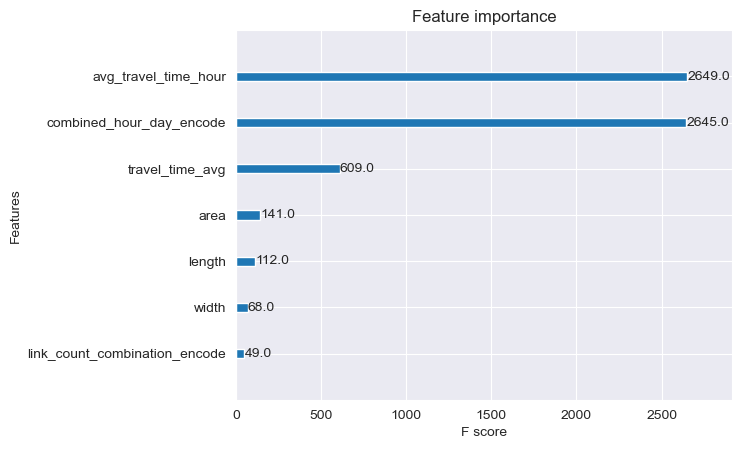

In [12]:
# 初始化模型
# 设置参数
# 训练模型
# 预测结果与评估
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
#feature_importances
plot_importance(xgb_reg)
plt.show()


In [13]:
from sklearn.feature_selection import SelectFromModel

#xgb的特征选择
thresholds = sorted(xgb_reg.feature_importances_)
for thresh in thresholds:
    selection = SelectFromModel(xgb_reg, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Thresh={thresh}, n={select_X_train.shape[1]}, MSE: {mse}")

Thresh=0.0009906901977956295, n=7, MSE: 0.22841158189028937
Thresh=0.0011382222874090075, n=6, MSE: 0.2284084477722706
Thresh=0.0012109351810067892, n=5, MSE: 0.22841354506195005
Thresh=0.0016268695471808314, n=4, MSE: 0.2284167474819784
Thresh=0.0016681550769135356, n=3, MSE: 0.2287174417231232
Thresh=0.0026264081243425608, n=2, MSE: 0.2287165262139707
Thresh=0.9907387495040894, n=1, MSE: 0.22871313458641757


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 15516076, number of used features: 7
[LightGBM] [Info] Start training from score 2.355114
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean Squared Error: 0.22844817843263165


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

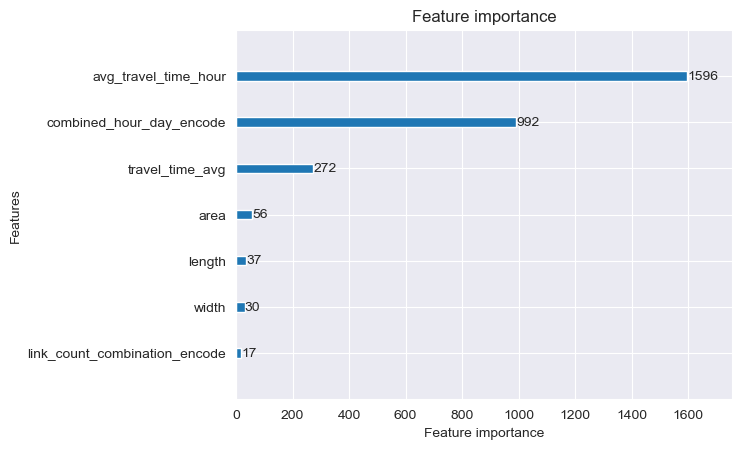

In [14]:
import lightgbm as lgb
lgb_reg = lgb.LGBMRegressor(objective='regression', n_estimators=100, learning_rate=0.05, max_depth=6)
lgb_reg.fit(X_train, y_train)
y_pred = lgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
#feature_importances
lgb.plot_importance(lgb_reg)

In [15]:
def train_models(X_train, y_train):
    models = {
        'xgboost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.05),
        'lightgbm': lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.05),
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        models[name] = model
    return models

In [16]:

from sklearn.linear_model import LinearRegression


def simple_average(models, X_test):
    predictions = np.column_stack([model.predict(X_test) for model in models.values()])
    return np.mean(predictions, axis=1)

# 加权平均法
def weighted_average(models, X_test, weights):
    predictions = np.column_stack([model.predict(X_test) for model in models.values()])
    return np.dot(predictions, weights)

# 堆叠法
def stacking(models, X_train, y_train, X_test):
    stacked_train = np.column_stack([model.predict(X_train) for model in models.values()])
    stacked_test = np.column_stack([model.predict(X_test) for model in models.values()])
    meta_model = LinearRegression()
    meta_model.fit(stacked_train, y_train)
    return meta_model.predict(stacked_test)

In [17]:

models = train_models(X_train, y_train)

# 选择融合方法
fusion_method = 'simple_average'  # 'simple_average', 'weighted_average', or 'stacking'

if fusion_method == 'simple_average':
    y_pred = simple_average(models, X_test)
elif fusion_method == 'weighted_average':
    weights = np.array([0.4, 0.6])  # Example weights
    y_pred = weighted_average(models, X_test, weights)
elif fusion_method == 'stacking':
    y_pred = stacking(models, X_train, y_train, X_test)
else:
    raise ValueError("Invalid fusion method selected.")

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)

print(f"{fusion_method} 模型的均方误差为:", mse)



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] [Info] Number of data points in the train set: 15516076, number of used features: 7
[LightGBM] [Info] Start training from score 2.355114
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
simple_average 模型的均方误差为: 0.2284214615399772


In [18]:
#weighted_average
#试试
weights = np.array([0.4, 0.6])  # Example weights
y_pred = weighted_average(models, X_test, weights)
mse = mean_squared_error(y_test, y_pred)
print(f"weighted_average 模型的均方误差为:", mse)
#试试 'stacking'
y_pred = stacking(models, X_train, y_train, X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"stacking 模型的均方误差为:", mse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
weighted_average 模型的均方误差为: 0.22842545793907068
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
stacking 模型的均方误差为: 0.22840421494182697


In [19]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} 模型的均方误差为:", mse)

xgboost 模型的均方误差为: 0.22841158189028937
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lightgbm 模型的均方误差为: 0.22844817843263165


## 消融实验

In [20]:
# def train_model(model_name, data, features, target='travel_time'):
#     X = data[features]
#     y = data[target]
# 
#     # 分割路径数据集
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 
#     # 训练路径数据模型
#     model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=6)
#     model.fit(X_train, y_train)
# 
#     # 预测路径数据
#     y_pred = model.predict(X_test)
# 
#     # 计算的均方误差
#     mse = mean_squared_error(y_test, y_pred)
#     print(f'Mean Squared Error: {mse}')
# 
#     # 保存模型
#     pickle.dump(xgb_reg, open(f'{model_name}.pkl', 'wb'))

### 1. Temporal feature and spatial feature

In [21]:
# features1 = time_features[1:-1] + road_features[1:]
# train_model('xgb_st', data_combine, features1)

### 2. Without temporal feature

In [22]:
# features2 = road_features[1:]
# train_model('xgb_s', data_combine, features2)

### 3. Without spatial feature

In [23]:
# features3 = time_features[1:-1]
# train_model('xgb_t', data_combine, features3)